# Data Analysis: European Social Survey (ESS) | Media Use | Germany

NOTE: 
* Please reference *media-use-germany-data-prep.ipynb* and *README.md* for information about the data source, data documentaion and further notes.
* When interpreting the following findings, please keep in mind that features like political interest, media use etc. are based on a self-assesment of the respondents during an interview. Effects like common-method variance might be present.

## Step 0: Load Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.preprocessing import StandardScaler as scaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz, plot_tree
from imblearn.under_sampling import RandomUnderSampler
from six import StringIO  
from IPython.display import Image  
import pydotplus

sns.set()
%matplotlib inline

In [2]:
df = pd.read_csv('data/EuropeanSocialSurvey_Round_1-5_Germany_clean.csv', index_col=0)
df.head()

,cseqno,essround,tvtot,tvpol,rdtot,rdpol,nwsptot,nwsppol,ppltrst,pplfair,...,imptrad,impfun,prtvde1_all,prtvde2_all,prtclde_all,prtmbde_all,marital_all,lnghom1_all,lnghom2_all,hincome_approx
0,66876,1,7.0,0.0,0.0,66.0,0.0,66.0,0,5,...,6.0,1.0,66.0,66.0,66.0,66.0,4.0,GER,000,1.0
1,66877,1,5.0,2.0,6.0,0.0,2.0,2.0,6,6,...,1.0,1.0,2.0,4.0,66.0,66.0,4.0,GER,000,2.0
2,66878,1,5.0,2.0,7.0,2.0,1.0,1.0,0,0,...,1.0,3.0,66.0,66.0,6.0,66.0,1.0,GER,000,2.0
3,66879,1,4.0,2.0,6.0,2.0,2.0,1.0,2,3,...,3.0,3.0,2.0,8.0,2.0,66.0,1.0,GER,000,3.0
4,66880,1,3.0,0.0,0.0,66.0,1.0,1.0,0,7,...,5.0,5.0,66.0,66.0,66.0,66.0,1.0,GER,000,2.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14401 entries, 0 to 14486
Columns: 118 entries, cseqno to hincome_approx
dtypes: float64(37), int64(79), object(2)
memory usage: 13.1+ MB


## Step 1: Explore Data

### Step 1.1 Explore Media Use

Features concerning media use:

* rdpol: Radio listening, news/politics/current affairs on average weekday
* rdtot: Radio listening, total time on average weekday
* tvpol: TV watching, news/politics/current affairs on average weekday
* tvtot: TV watching, total time on average weekday
* nwsppol: Newspaper reading, politics/current affairs on average weekday
* nwsptot: Newspaper reading, total time on average weekday

Encoding:

0 = No time at all || 1 = Less than 0,5 hour || 2 = 0,5 hour to 1 hour || 3 = More than 1 hour, up to 1,5 hours || 4 = More than 1,5 hours, up to 2 hours || 5 = More than 2 hours, up to 2,5 hours || 6 = More than 2,5 hours, up to 3 hours || 7 = More than 3 hours || 66 = Not applicable || 77 = Refusal || 88 = Don't know || 99 = No answer


In [4]:
def plot_media_use_heatmap_by(df, medium, by, onlyTotal = False):
    '''
    INPUT
    df - Pandas dataframe
    medium - Medium, which columns should be plotted ({'nwsp': 'Newspaper', 'tv': 'Television', 'rd': 'Radio'})
    by - The second variable to plot
    onlyTotal - Boolean variable that indicates wether only the total media use should be plotted
        
    This function
    1. removes answeres 'Not applicable', 'Refusal', 'Don't know', 'No answer'
    2. plots the counts of answers for media use in total and for news/politics/current by the given "by" parameter
    '''
    mediums = {'nwsp': 'Newspaper', 'tv': 'Television', 'rd': 'Radio'}
    df_tot = df[df[medium+'tot'].isin(range(0,8))]
    
    fig = plt.figure(figsize=(15,4))
    ax1 = fig.add_subplot(121)
    
    sns.heatmap(data=df_tot.groupby([by, medium+'tot']).size().unstack(fill_value=0), ax=ax1)
    ax1.set_title(mediums[medium] + ' (total time on average weekday) - Answer Counts by ' + by)

    if not onlyTotal:
        df_pol = df[df[medium+'pol'].isin(range(0,8))]
        ax2 = fig.add_subplot(122)
        sns.heatmap(data=df_pol.groupby([by, medium+'pol']).size().unstack(fill_value=0), ax=ax2)
        ax2.set_title(mediums[medium] + ' (politics/current affairs on average weekday) - Answer Counts by' + by)

    plt.show()

In [5]:
def plot_media_use_stacked_bars_by(df, medium, by, legend={1: 1, 2: 2}):
    '''
    INPUT
    df - Pandas dataframe
    medium - Medium, which columns should be plotted ({'nwsp': 'Newspaper', 'tv': 'Television', 'rd': 'Radio'})
    by - The second variable to plot
    legend - Dictonary that maps binary category to names (optional)
        
    This function
    1. removes answeres 'Not applicable', 'Refusal', 'Don't know', 'No answer'
    2. plots the counts of answers for media use in total and for news/politics/current by gender
    '''
    mediums = {'nwsp': 'Newspaper', 'tv': 'Television', 'rd': 'Radio'}
    df_tot = df[df[medium+'tot'].isin(range(0,8))]
    df_pol = df[df[medium+'pol'].isin(range(0,8))]
    
    bar_names_tot = df_tot[medium+'tot'].value_counts().sort_index().keys()
    bar_names_pol = df_pol[medium+'pol'].value_counts().sort_index().keys()

    fig = plt.figure(figsize=(15,4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    p1 = ax1.bar(bar_names_tot, height=df_tot[df_tot[by]==1][medium+'tot'].value_counts().sort_index())
    p2 = ax1.bar(bar_names_tot, height=df_tot[df_tot[by]==2][medium+'tot'].value_counts().sort_index(), bottom=df_tot[df_tot[by]==1][medium+'tot'].value_counts().sort_index())
    ax1.legend((p1[0], p2[0]), (legend[1], legend[2]))
    
    p3 = ax2.bar(bar_names_pol, height=df_pol[df_pol[by]==1][medium+'pol'].value_counts().sort_index())
    p4 = ax2.bar(bar_names_pol, height=df_pol[df_pol[by]==2][medium+'pol'].value_counts().sort_index(), bottom=df_pol[df_pol[by]==1][medium+'pol'].value_counts().sort_index())
    ax2.legend((p3[0], p4[0]), (legend[1], legend[2]))

    ax1.set_title('Answer Counts by ' + mediums[medium] + ' use and ' + by)
    ax2.set_title('Answer Counts by ' + mediums[medium] + ' use for politics/current affairs and ' + by)

    plt.show()

**Explore Media Use By Round/ Time (essround)**

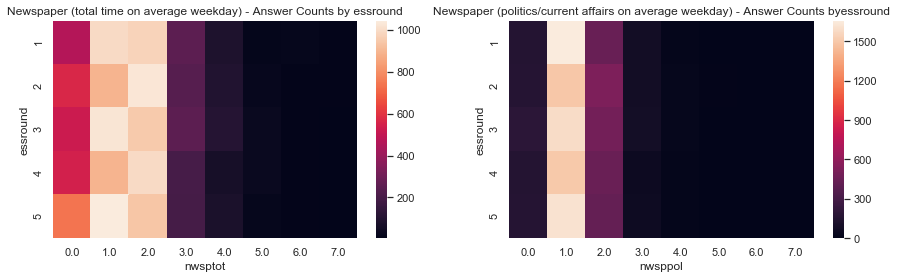

In [6]:
plot_media_use_heatmap_by(df, 'nwsp', 'essround')

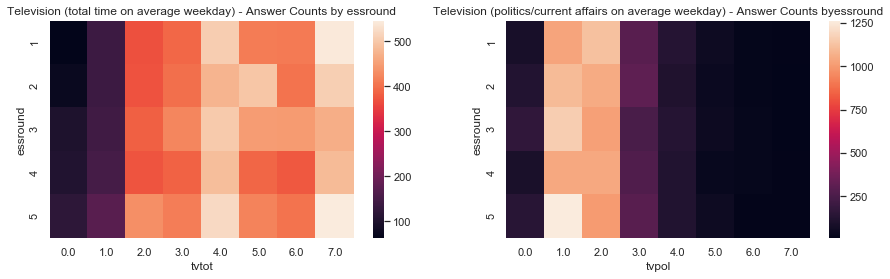

In [7]:
plot_media_use_heatmap_by(df, 'tv', 'essround')

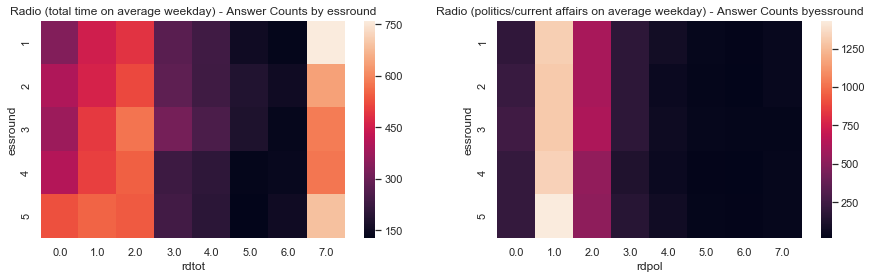

In [8]:
plot_media_use_heatmap_by(df, 'rd', 'essround')

*Explore Media Use By Round/ Time (essround) - Discussion*
* NOTE: The plots use differnet scales, the colors are only comparable within one plot. We can still compare the different patterns and trends though.
* The typical range of average time spend with newspaper is much tighter than for television and radio.
* For all three mediums the color gradient for the answer code "0.0" shows an increase of people answering they don't use the medium at all (total time).
* Even though the typical total time ranges differ between the mediums, the typical time range for consuming politics seems ot be "1 = Less than 0,5 hour" for all of them (for television closely followed by "2 = 0,5 hour to 1 hour").

**Explore Media Use By Political Interest (polintr)**

Encoding: 1 = Very interested || 2 = Quite interested || 3 = Hardly interested || 4 = Not at all interested || 7 = Refusal || 8 = Don't know || 9 = No answer

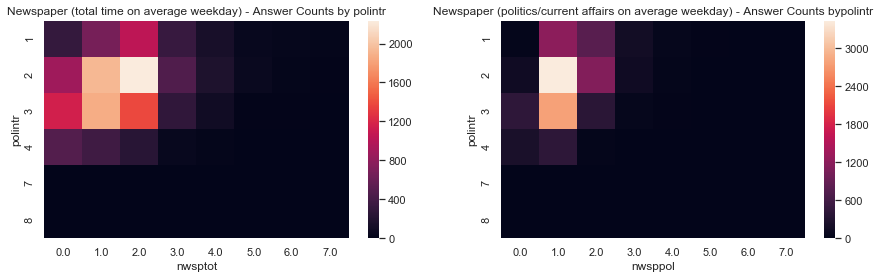

In [9]:
plot_media_use_heatmap_by(df, 'nwsp', 'polintr')

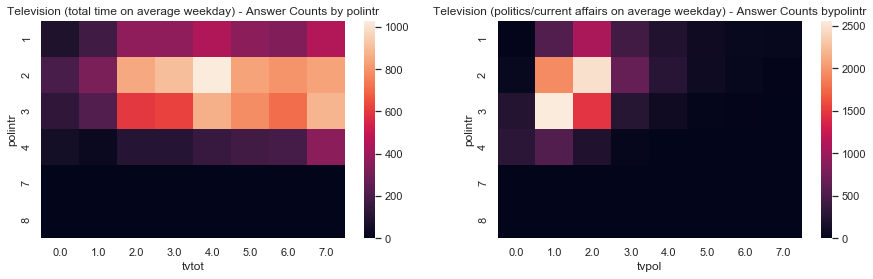

In [10]:
plot_media_use_heatmap_by(df, 'tv', 'polintr')

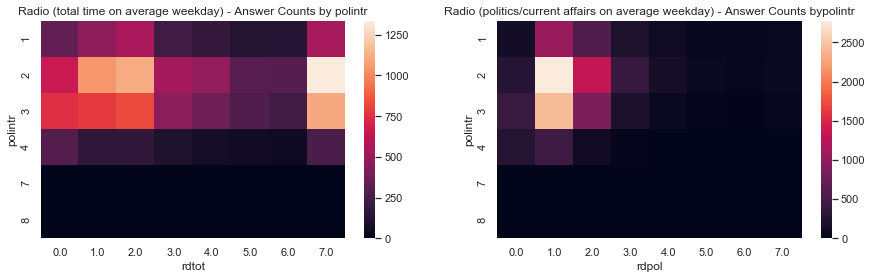

In [11]:
plot_media_use_heatmap_by(df, 'rd', 'polintr')

*Explore Media Use By Political Interest - Discussion*
* Even within the group of politically interested (1-2), the media use for politics does not seem to be much higher than category 1-2.
* On the other hand, a lot of the hardly interested (3) still report a (week)daily political media use (especially category 1) over all mediums.

**Explore Media Use By Gender (gndr)**

Encoding: 1 = Male || 2 = Female || 9 = No answer

In [12]:
# Check that gender is equally distributed within the answeres
df['gndr'].value_counts()

2    7217
1    7184
Name: gndr, dtype: int64

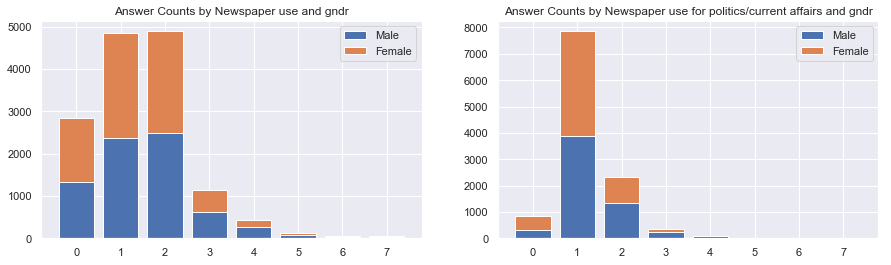

In [13]:
plot_media_use_stacked_bars_by(df, 'nwsp', 'gndr', {1: "Male", 2: "Female"})

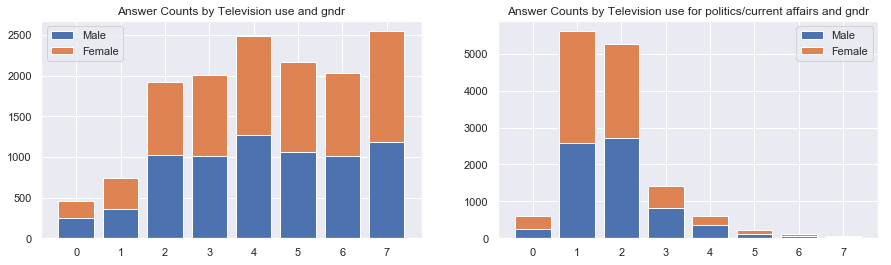

In [14]:
plot_media_use_stacked_bars_by(df, 'tv', 'gndr', {1: "Male", 2: "Female"})

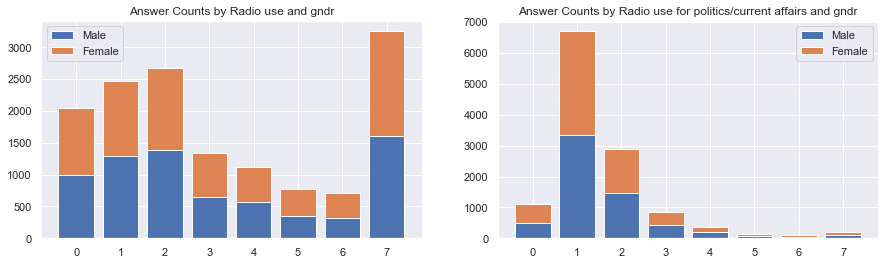

In [15]:
plot_media_use_stacked_bars_by(df, 'rd', 'gndr', {1: "Male", 2: "Female"})

*Explore Media Use By Gender (gndr) - Discussion*
* The plots don't show drastic differences between gender
* The category "0" (No time at all) seemd to have been picked a bit more often by women than by men, except for "television total"
* Concerning the total media use for both genders, newspaper shows the highest amount of "No time at all" answers (>3.500) followed by radio (~2000) and finally tv (<500)

## Step 2: Find Answers

### Step 2 - Question 1: Traditionalism & Newspaper Use
Are respondents who affirm the importance to follow traditions and customs more likely to read newspapers than respondents who disagree?

*Feature imptrad:*
* imptrad: "Important to follow traditions and customs"
* Encoding: 1 = Very much like me || 2 = Like me || 3 = Somewhat like me || 4 = A little like me || 5 = Not like me || 6 = Not like me at all || 7 = Refusal || 8 = Don't know || 9 = No answer


In [16]:
# Create subset of the data holding the relevant features
dfq1 = df[['nwsptot', 'imptrad']]
dfq1.head()

,nwsptot,imptrad
0,0.0,6.0
1,2.0,1.0
2,1.0,1.0
3,2.0,3.0
4,1.0,5.0


In [17]:
# Remove rows where no answer has been provided for nwsppol or imptrad
nwsptot_no_answer = (66, 77, 88, 99)
imptrad_no_answer = (7, 8, 9)

dfq1 = dfq1[np.invert(dfq1['nwsptot'].isin(nwsptot_no_answer) | dfq1['imptrad'].isin(imptrad_no_answer))]

dfq1.head()

,nwsptot,imptrad
0,0.0,6.0
1,2.0,1.0
2,1.0,1.0
3,2.0,3.0
4,1.0,5.0


Text(0.5, 1.0, 'Linear regression of traditionalism (independent) and newspaper user (dependent)')

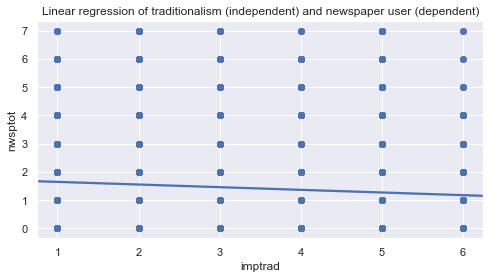

In [18]:
# Plot linear regression (independent variable: traditionalism, dependen variable: newspaper use)
sns.set(rc={'figure.figsize':(8,4)})
ax = sns.regplot(x='imptrad', y='nwsptot', data=dfq1)
ax.set_title("Linear regression of traditionalism (independent) and newspaper user (dependent)")

In [19]:
# Create dummy variables as preparation for the correlation matrix
dfq1a = pd.get_dummies(dfq1, columns=['nwsptot', 'imptrad'])

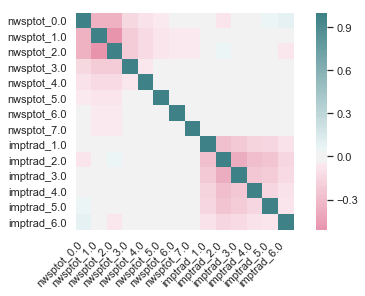

In [20]:
# Plot correlation matrix
ax = sns.heatmap(dfq1a.corr(), center=0, square=True, cmap=sns.diverging_palette(0, 200, n=150))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

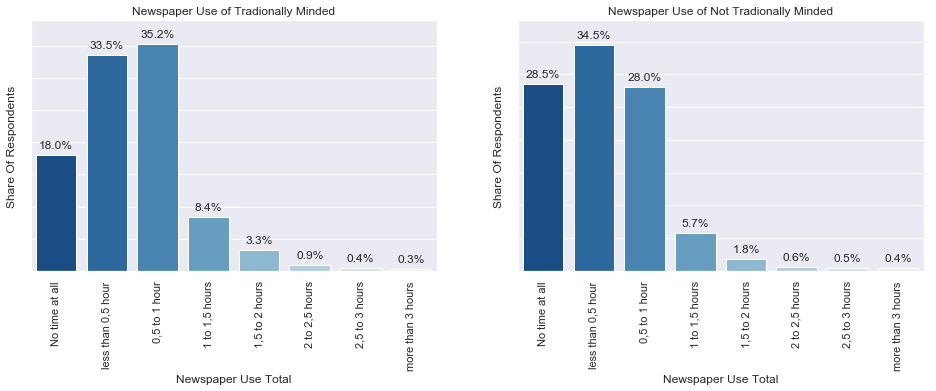

In [21]:
# Aggregate answers from traditional minded respondents (1 = Very much like me || 2 = Like me || 3 = Somewhat like me || 4 = A little like me) and calculate the share in each response category
dfq1b = dfq1[dfq1['imptrad'].isin([1,2,3,4])].groupby('nwsptot', as_index=False).count().sort_index()
dfq1b['imptrad'] = dfq1b['imptrad'].apply(lambda x: x/dfq1b['imptrad'].sum())

# Aggregate answers from traditional minded respondents (5 = Not like me || 6 = Not like me at all) and calculate the share in each response category
dfq1c= dfq1[dfq1['imptrad'].isin([5,6])].groupby('nwsptot', as_index=False).count().sort_index()
dfq1c['imptrad'] = dfq1c['imptrad'].apply(lambda x: x/dfq1c['imptrad'].sum())

# Set up subplots
fig = plt.figure(figsize=(16,6))
fig.subplots_adjust(bottom=0.3)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Plot chart for traditional group with title
ax1 = sns.barplot(x='nwsptot', y='imptrad', data=dfq1b, palette='Blues_r', ax=ax1)
ax1.set_title("Newspaper Use of Tradionally Minded")

# Plot chart for non traditional group
ax2 = sns.barplot(x='nwsptot', y='imptrad', data=dfq1c, palette='Blues_r')
ax2.set_title("Newspaper Use of Not Tradionally Minded")

# Add annotations and format axis
for ax in [ax1, ax2]:
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.1%'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

    # Format margins to get more space for the annotations
    plot_margin = 0.02
    x0, x1, y0, y1 = ax.axis()
    ax.axis((x0, x1, y0, y1 + plot_margin))

    # Add title and set axis labels
    ax.set_ylabel('Share Of Respondents')    
    ax.set_xlabel('Newspaper Use Total')    
    ax.set_yticklabels([])
    ax.set_xticklabels(['No time at all', 'less than 0,5 hour', '0,5 to 1 hour', 
                        '1 to 1,5 hours', '1,5 to 2 hours', 
                        '2 to 2,5 hours', '2,5 to 3 hours', 
                        'more than 3 hours'], rotation=90)

plt.savefig("fig1-nwsp-use-tradional.png",type="png",dpi=300)

plt.show()

*Step 2 - Question 1: Traditionalism & Newspaper Use - Conclusion*
* The first plot only showed a very flat regression line, indicating that there is no strong connection between the respondents subjective importance of tradition and the intensity if their newspaper use.
* This observation was confirmed by the correlation plot, which even shows weaker signs of a connection.
* Comparing the share of newpaper use intensities between the two groups of more and less tradionally minded repondents also showed only slightly differences: 
    * 69% of the more traditional respondents read the newspaper up to an hour per weekday, 18% don't read it at all.
    * Within the less/ not traditional respondents, 63% read the newspaper up to an hour per week. 
    * Only the number of less/ non traditional minded respondents with no newspaper use at all (28%) is at least noticeably higher (+10%).

Finally, even though slightly differences could be identified, the self-assesment of how important tradition is to the respondent doesn't seem to be a good indicator for his or her newspaper use.

### Step 2 - Question 2: Political newspaper use & participation in the last national vote
Are respondents with a regularly political newspaper more likely to have voted in the last national election?

* Feature: vote (Voted last national election)
* Encoding: 1 = Yes || 2 = No || 3 = Not eligible to vote || 7 = Refusal || 8 = Don't know || 9 = No answer

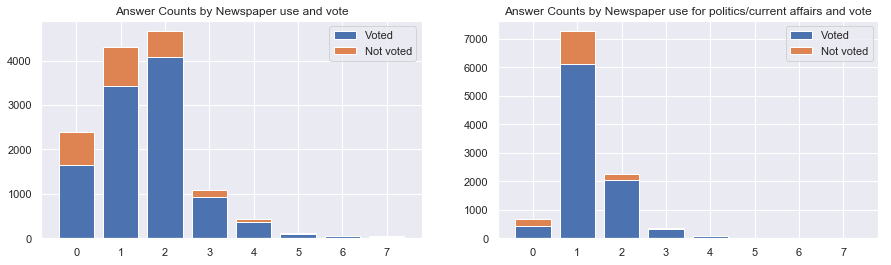

In [22]:
plot_media_use_stacked_bars_by(df[df['vote'].isin([1,2])], 'nwsp', 'vote', {1: "Voted", 2: "Not voted"})

In [23]:
# Create subset of the data holding the relevant features and remove rows where no answer has been provided
nwsptot_no_answer = (66, 77, 88, 99)
vote_no_answer = (3, 7, 8, 9)

dfq2 = df[['nwsppol','vote']]
dfq2 = dfq2[np.invert(dfq2['nwsppol'].isin(nwsptot_no_answer) | dfq2['vote'].isin(vote_no_answer))]

dfq2.head()

,nwsppol,vote
1,2.0,1
2,1.0,2
3,1.0,1
4,1.0,2
5,1.0,2


Text(0.5, 1.0, 'Linear regression of newspaper user (independent) and vote last national election (dependent)')

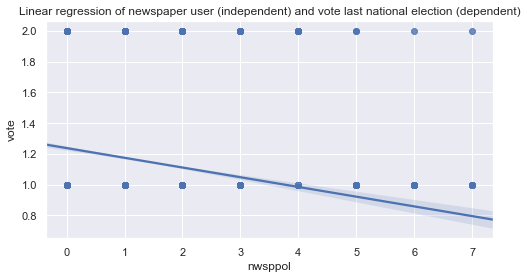

In [24]:
# Plot linear regression (independent variable: newspaper use, dependen variable: vote)
sns.set(rc={'figure.figsize':(8,4)})
ax = sns.regplot(x='nwsppol', y='vote', data=dfq2)
ax.set_title("Linear regression of newspaper user (independent) and vote last national election (dependent)")

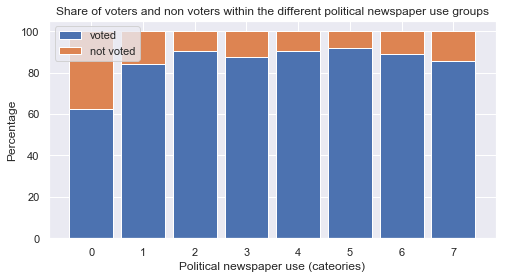

In [25]:
# Group data by political newspaper use and vote
dfq2a = dfq2.groupby(['nwsppol', 'vote'], as_index=False).size().unstack(fill_value=0)

# Transform values to percentage
totals = [i+j for i,j in zip(dfq2a[1], dfq2a[2])]
voted = [i / j * 100 for i,j in zip(dfq2a[1], totals)]
not_voted = [i / j * 100 for i,j in zip(dfq2a[2], totals)]

# Create Bars
barWidth = 0.85
plt.bar(dfq2a.index, voted, edgecolor='white', width=barWidth)
plt.bar(dfq2a.index, not_voted, bottom=voted, edgecolor='white', width=barWidth)

# Custom x axis
plt.xlabel("Political newspaper use (cateories)")
plt.ylabel("Percentage")
plt.legend(("voted", "not voted"))
plt.title("Share of voters and non voters within the different political newspaper use groups")

# Plot the share of voted and not voted within the politival newspaper use categories
plt.show()

In [26]:
# Create a new boolean feature indication wether a person uses newspaper for political information or not
dfq2c = dfq2
dfq2c['nwsppol_bool'] = dfq2c['nwsppol'].apply(lambda x: 0 if x == 0 else 1)
dfq2c = dfq2c.groupby(['vote', 'nwsppol_bool'], as_index=False).size().unstack(fill_value=0)
dfq2c

nwsppol_bool,0,1
vote,,
1,425,8584
2,256,1434


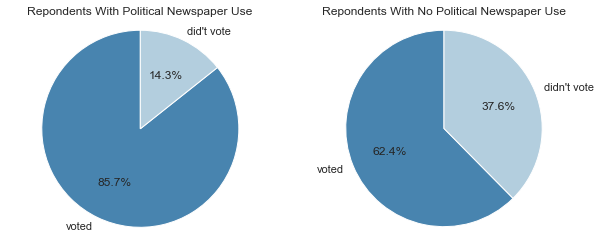

In [27]:
# Create a pie chart to show the share of voters/ non voters within the nwsppol_bool groups
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.pie(dfq2c[1], labels=["voted","did't vote"], autopct='%1.1f%%', startangle=90, colors=['#4884af', '#b3cede'])
ax1.axis('equal')  # Equal aspect ratio to ensure that pie is drawn as a circle.
ax1.set_title("Repondents With Political Newspaper Use")

ax2.pie(dfq2c[0], labels=["voted","didn't vote"], autopct='%1.1f%%', startangle=90, colors=['#4884af', '#b3cede'])
ax2.axis('equal') 
ax2.set_title("Repondents With No Political Newspaper Use")

plt.savefig("fig2-nwsp-use-vote.png",type="png",dpi=300)

plt.show()

Step 2 - Question 2: Political newspaper use & participation in the last vote - Conclusion

The linear regression plot suggests that the respondents with a (higher) political newspaper use are more likely to have voted. Anyhow, further visualizations of the data show, that the main difference lies between people with and without political newspaper use. Meaning: The amount of time a person spends on political newspaper use is less of an indicator for wether he/ she has voted than the pure fact if the person uses newspaper for political information at all. 
This last statement could be set out visually by plotting the "voted" vs. "didn't vote" share within those two groups: Only 14 % of respondents with political newspaper use did not vote in the last election whereas in the group of respondents without political newspaper use, more than 37 % (+ 23 %) didn't vote.

### Step 2 - Question 3: Identify Non Newspaper Users Based On Demographics & Party Preference
Can we identfy people who don't use newspapers based on their socio-demographic profile and their answer to which party they feel closer to?

**Features in the socio-demographic profile**

* *Feature marital_all*
    * Legal marital status, post coded
    * Encoding: 1 = Legally married/ Legally registered civil union/ civil partnership || 2 = Divorced/ Dissolved civil partnership || 3 = Widowed/ civil partner died || 4 = Never married or in legally registered civil union || 77 = Refusal || 88 = Don't know || 99 = No answer
* *Feature chldhm*
    * Children living at home or not
    * Encoding: 1 = Respondent lives with children at household grid || 2 = Does not || 9 = Not available
* *Feature eisced*
    * Highest level of education, ES - ISCED
    * Encoding: 0 = Not possible to harmonise into ES-ISCED || 1 = ES-ISCED I , less than lower secondary || 2 = ES-ISCED II, lower secondary || 3 = ES-ISCED IIIb, lower tier upper secondary || 4 = ES-ISCED IIIa, upper tier upper secondary || 5 = ES-ISCED IV, advanced vocational, sub-degree || 6 = ES-ISCED V1, lower tertiary education, BA level || 7 = ES-ISCED V2, higher tertiary education, >= MA level || 55 = Other || 77 = Refusal || 88 = Don't know || 99 = No answer
* *Feature eduyrs*
    * Years of full-time education completed
    * Endocing: years || 77 = Refusal || 88 = Don't know || 99 = No answer
* *Feature mnactic*
    * Main activity, last 7 days. All respondents. Post coded
    * Encoding: 1 = Paid work || 2 = Education || 3 = Unemployed, looking for job || 4 = Unemployed, not looking for job || 5 = Permanently sick or disabled || 6 = Retired || 7 = Community or military service || 8 = Housework, looking after children, others || 9 = Other || 66 = Not applicable || 77 = Refusal || 88 = Don't know || 99 = No answer
* *Feature hincome_approx*
    * Household's total net income, all sources, post coded and roughly unified
    * Encoding: 1 = [0-12000) || 2 = [12000-24000) || 3 = [24000-36000) || 4 = [36000-60000) || 5 = [60000-infinity) || 77 = Refusal || 88 = Don't know || 99 = No answer
* *Feature edulvlpa (excluded)*
    * Partner's highest level of education - left out, because nit applicable to all respondents
    * Not used in further analysis because it is assumed that it's not applicable in a big subset of the data due to the respondent not having a partner
* *Feature agea*
    * Age of respondent, calculated
    * Encoding: years || 999 = Not available
* *Feature gndr*
    * Gender
    * Encoding: 1 = Male || 2 = Female || 9 = No answer
    
**Feature for political party preference**

Several features are available concerning political parties, for example which party has been voted for and the party membership. However, for the further analysis only the feature prtclde_all (Which party feel closer to, Germany) will be used, because unlike the others, it doesn't naturally exclude respondents who did not vote or are not a member of a political party.

* *Feature prtclde_all*
    * Which party feel closer to, Germany, post coded
    * Encoding: 1 || Social Democratic Party (SPD) || 2 = Christian Democratic Union (CDU/CSU) || 3 = Green Party (Bündnis 90/Die Grünen) || 4 = Liberal Democratic Party (FDP) || 5 = Party of Democratic Socialism (PDS) || 6 = Republican Party (Republikaner) || 7 = National Democratic Party/German People's Union (NPD/DVU) || 8 = Other || 66 = Not applicable || 77 = Refusal || 88 = Don't know || 99 = No answer

#### a) Create subset with relevant data

In [28]:
# Create subset with the relevant features and remove 
dfq3 = df[['chldhm', 'eisced', 'eduyrs', 'mnactic', 'hincome_approx', 'agea', 'gndr', 'prtclde_all', 'nwsptot']]
dfq3.head()

,chldhm,eisced,eduyrs,mnactic,hincome_approx,agea,gndr,prtclde_all,nwsptot
0,2,3,10,3,1.0,26,1,66.0,0.0
1,2,3,11,1,2.0,31,1,66.0,2.0
2,2,3,9,1,2.0,60,1,6.0,1.0
3,2,3,10,8,3.0,48,2,2.0,2.0
4,1,3,9,3,2.0,32,1,66.0,1.0


In [29]:
dfq3.shape

(14401, 9)

In [30]:
# Identify encodings for missing values
dict_missing_values = {
    'marital_all': [77, 88, 99], 'chldhm': [9], 'eisced': [0, 55, 77, 88, 99], 'eduyrs': [77, 88, 99], 
    'mnactic': [66, 77, 88, 99], 'hincome_approx': [77, 88, 99], 'prtclde_all': [66, 77, 88, 99],
    'nwsptot': [66, 77, 88, 99], 'agea': [999], 'gndr': [9]
}

In [31]:
# Remove rows with missing values
for col in dfq3.columns:
    dfq3 = dfq3[np.invert(dfq3[col].isin(dict_missing_values[col]))]
    
dfq3.shape

(5154, 9)

#### b) Create, transform and scale features

In [32]:
# Create new boolean var "no pol newspaper use"
dfq3['no_pol_nwsp_use'] = dfq3['nwsptot'].apply(lambda x: 1 if x == 0 else 0)

# Drop original column nwsppol
dfq3 = dfq3.drop(columns=['nwsptot'])

# Check class distribution
dfq3['no_pol_nwsp_use'].value_counts()

0    4360
1     794
Name: no_pol_nwsp_use, dtype: int64

In [33]:
# Transform encding of the binary feature chldhm from [1,2] to [0,1]
dfq3['chldhm'] = dfq3['chldhm'].apply(lambda x: 1 if x == 1 else 0)

In [34]:
# Apply One-hot-encoding to nominal categorical features (Note: ordinal categorical features like eisced, where a higher number indicates a higher educatio, are not transformed)
nominal_features = ['mnactic', 'gndr', 'prtclde_all']
dfq3 = pd.get_dummies(dfq3, columns=nominal_features)
dfq3.head()

,chldhm,eisced,eduyrs,hincome_approx,agea,no_pol_nwsp_use,mnactic_1,mnactic_2,mnactic_3,mnactic_4,...,gndr_1,gndr_2,prtclde_all_1.0,prtclde_all_2.0,prtclde_all_3.0,prtclde_all_4.0,prtclde_all_5.0,prtclde_all_6.0,prtclde_all_7.0,prtclde_all_8.0
2,0,3,9,2.0,60,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,3,10,3.0,48,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
5,0,4,13,1.0,25,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
6,0,3,12,3.0,60,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
7,1,2,11,2.0,46,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [35]:
# Scale features (Standardize features by removing the mean and scaling to unit variance)
features = dfq3.drop(columns=['no_pol_nwsp_use'])
y = dfq3['no_pol_nwsp_use']

X = pd.DataFrame(scaler().fit_transform(features)) # Fit and transform the data
X.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.687744,-0.708260,-1.367753,-0.766908,0.495585,1.034752,-0.235582,-0.194032,-0.120694,-0.122338,...,0.906557,-0.906557,-0.693873,-0.714219,-0.429916,-0.22388,-0.346335,11.603085,-0.079042,-0.113893
1,-0.687744,-0.708260,-1.084098,0.140911,-0.215145,-0.966415,-0.235582,-0.194032,-0.120694,-0.122338,...,-1.103075,1.103075,-0.693873,1.400131,-0.429916,-0.22388,-0.346335,-0.086184,-0.079042,-0.113893
2,-0.687744,-0.109936,-0.233132,-1.674727,-1.577379,-0.966415,-0.235582,-0.194032,-0.120694,-0.122338,...,0.906557,-0.906557,-0.693873,-0.714219,-0.429916,-0.22388,2.887379,-0.086184,-0.079042,-0.113893
3,-0.687744,-0.708260,-0.516787,0.140911,0.495585,-0.966415,-0.235582,-0.194032,-0.120694,-0.122338,...,-1.103075,1.103075,-0.693873,1.400131,-0.429916,-0.22388,-0.346335,-0.086184,-0.079042,-0.113893
4,1.454029,-1.306584,-0.800442,-0.766908,-0.333600,1.034752,-0.235582,-0.194032,-0.120694,-0.122338,...,0.906557,-0.906557,-0.693873,1.400131,-0.429916,-0.22388,-0.346335,-0.086184,-0.079042,-0.113893


#### c) Implement machine learning model

In [36]:
def print_scores(y_train=None, y_train_pred=None, y_test=None, y_test_pred=None, beta=0.5):
    '''
    INPUT
    y_train - True y values for training set
    y_train_pred - Predicted y values for training set
    y_test - True y values for testing set
    y_test_pred - Predicted y values for testing set
    beta - Parameter for f-beta score
        
    This function calculates and print several perforance meetrics for model evaluation.
    '''
    
    if not (isinstance(y_train, type(None)) | isinstance(y_train_pred, type(None))):
        print("\nModel prediction on training data\n------")
        print("Accuracy on training data: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
        print("Precision on training data: {:.4f}".format(precision_score(y_train, y_train_pred)))
        print("Recall on training data: {:.4f}".format(recall_score(y_train, y_train_pred)))
        print("F-score on training data: {:.4f}".format(fbeta_score(y_train, y_train_pred, beta = beta)))
    
    if not (isinstance(y_test, type(None)) | isinstance(y_test_pred, type(None))):
        print("\nModel prediction on testing data\n------")
        print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, y_test_pred)))
        print("Precision on testing data: {:.4f}".format(precision_score(y_test, y_test_pred)))
        print("Recall on testing data: {:.4f}".format(recall_score(y_test, y_test_pred)))
        print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, y_test_pred, beta = beta)))

**First approach: Simple DecisionTreeClassifier**

In [37]:
# Split the 'features' and 'pol_media_use' (y) data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train1.shape[0]))
print("Testing set has {} samples.".format(X_test1.shape[0]))

Training set has 4123 samples.
Testing set has 1031 samples.


In [38]:
# Create and fit a DecisionTreeClassifier
tree1 = DecisionTreeClassifier().fit(X_train1, y_train1)

# Predict y on training and testing data
y_train_pred1 = tree1.predict(X_train1)
y_test_pred1 = tree1.predict(X_test1)

# Print metrics for model evaluation
print_scores(y_train1, y_train_pred1, y_test1, y_test_pred1)


Model prediction on training data
------
Accuracy on training data: 0.9949
Precision on training data: 1.0000
Recall on training data: 0.9663
F-score on training data: 0.9931

Model prediction on testing data
------
Accuracy on testing data: 0.7565
Precision on testing data: 0.2044
Recall on testing data: 0.1647
F-score on testing data: 0.1950


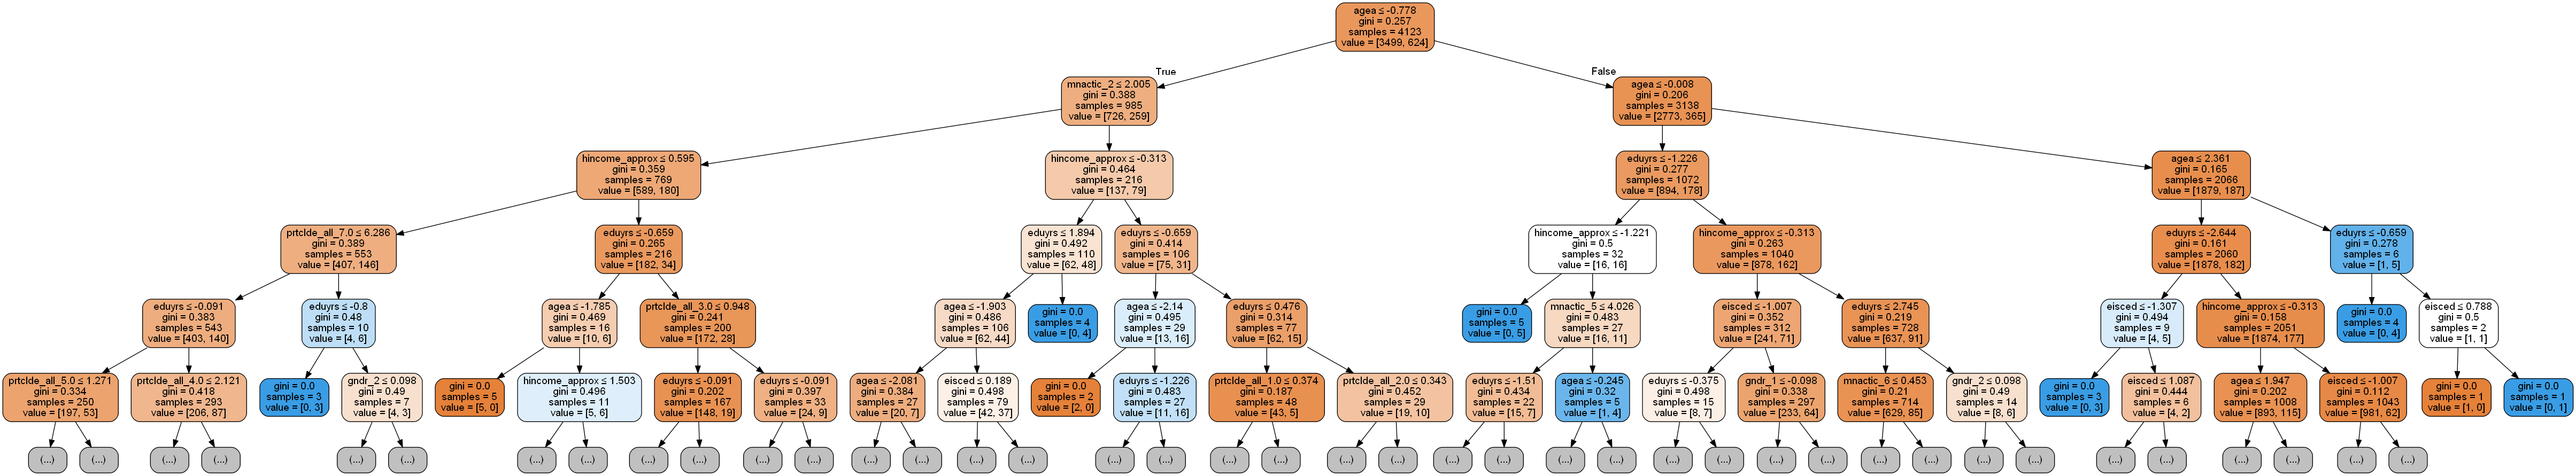

In [39]:
# Create graphical visualization of the decision tree model (up to a depth of 5)
dot_data = StringIO()
export_graphviz(tree1, out_file=dot_data, max_depth=5,  
                feature_names = features.columns,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png(), height=20)

*Conclusion To First approach (Simple DecisionTreeClassifier)*
* As seen above, the number of newspaper users (about 4300) and non newspaper users (about 800) are quite imbalanced.
* Our goal is to identify the fewer number of respondent with no newspaper use, therefore we care about a high recall score in our model.
* The model performance only shows a recall score of 0,1765 though, it cannot be used to identify non newspaper readers at all.

**Second apporach: DecisionTreeClassifier with undersampled data (compensating class imbalance)**

The mentioned imbalance between the two classes usually leads to bad performing models. To combat this issue, the training and testing data set should be balanced, which can be accomplished by down-sampling the data (reducing the number of entries with the overrepresented class).

In [40]:
# Handle imbalance classes by down-sampling before training the model
tree2 = DecisionTreeClassifier(random_state=42)
sampler = RandomUnderSampler(random_state=tree2.random_state)
X_sample, y_sample = sampler.fit_sample(X, y)

In [41]:
# Split the sampled data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_sample, y_sample, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train2.shape[0]))
print("Testing set has {} samples.".format(X_test2.shape[0]))

Training set has 1270 samples.
Testing set has 318 samples.


In [42]:
# Fit the model with down-sampled data
tree2 = tree2.fit(X_train2, y_train2)

# Evaluate the model performance
y_train_pred2 = tree2.predict(X_train2)
y_test_pred2 = tree2.predict(X_test2)

# Print metrics for model evaluation
print_scores(y_train2, y_train_pred2, y_test2, y_test_pred2)


Model prediction on training data
------
Accuracy on training data: 0.9969
Precision on training data: 1.0000
Recall on training data: 0.9937
F-score on training data: 0.9987

Model prediction on testing data
------
Accuracy on testing data: 0.5723
Precision on testing data: 0.5640
Recall on testing data: 0.6139
F-score on testing data: 0.5733


*Conclusion To Second apporach (DecisionTreeClassifier with undersampled data)*
* Downsampling the data made a huge difference in the model performance.
* The recall score could be increased from 0.1765 to 0.6139.
* Anyhow, with an accuracy of 0.5723 this model is just as good as random guessing.

**Third apporach: AdaBoostClassifier with undersampled data**

The DecisionTreeModel is known for overfitting (simply memorizing the training data) and is also called a weak learner. The overfitting can be combatted by using an ensemble algorithm, which combines several weak learner to a model that can be generlized better. Thus, the AdaBoostClassifier will be tested in the next step.

In [43]:
# Handle imbalance classes by down-sampling before training the model
ada_boost = AdaBoostClassifier(random_state=42)

# Fit the model with down-sampled data
ada_boost = ada_boost.fit(X_train2, y_train2)

# Evaluate the model performance
y_train_pred3 = ada_boost.predict(X_train2)
y_test_pred3 = ada_boost.predict(X_test2)

# Print metrics for model evaluation
print_scores(y_train2, y_train_pred3, y_test2, y_test_pred3)


Model prediction on training data
------
Accuracy on training data: 0.6724
Precision on training data: 0.6687
Recall on training data: 0.6855
F-score on training data: 0.6720

Model prediction on testing data
------
Accuracy on testing data: 0.6572
Precision on testing data: 0.6467
Recall on testing data: 0.6835
F-score on testing data: 0.6538


*Conclusion To Third apporach (AdaBoostClassifier with undersampled data)*
* By using a more sophisticated algorithm, we could increase both accuracy (from  0.5723 to 0.6572) as well as the recall score (from 0.6139 to 0.6538).
* But still, both values are not high enough to allow reliable predictions.

**Fourth apporach: AdaBoostClassifier with undersampled data and random grid search**

Another approach to increase a models performance is tuning its hyperparameters. To find a good combination of hyperparamters, we're going to use random grid search, which trains the model several times, always with a different combination of hyperparamters from a given set of possible values.

In [44]:
# The base estimator from which the boosted ensemble is built
base_estimator = [DecisionTreeClassifier(max_depth=1), 
                  DecisionTreeClassifier(max_depth=5), 
                  DecisionTreeClassifier(max_depth=10)]

# The maximum number of estimators at which boosting is terminated.
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Learning rate shrinks the contribution of each classifier by learning_rate
learning_rate = [0.001, 0.01, 0.1, 1.0]

# The algorithm determins wether to use real or discrete boosting algorithm
algorithm = ['SAMME', 'SAMME.R']

# Create the random grid
random_grid = {'base_estimator': base_estimator,
               'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'algorithm': algorithm}

In [59]:
# Use the random grid to search for best hyperparameters

# Create the base model to tune
ada = AdaBoostClassifier(random_state=0)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
ada_random = RandomizedSearchCV(estimator = ada, param_distributions = random_grid, 
                                n_iter = 100, cv = 3, verbose=2, random_state=0, 
                                scoring='balanced_accuracy', n_jobs = -1)

# Fit the random search model
ada_random.fit(X_train2, y_train2)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=None,
                                                learning_rate=1.0,
                                                n_estimators=50,
                                                random_state=0),
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'base_estimator': [DecisionTreeClassifier(class_weight=None,
                                                                                  criterion='gini',
                                                                                  max_depth=1,
                                                                                  ma...
                                                                                  min_impurity

In [60]:
# Identify the best estimator
best_random = ada_random.best_estimator_
best_random

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                               

In [61]:
# Evaluate the model performance of the best estimator
y_train_pred4 = best_random.predict(X_train2)
y_test_pred4 = best_random.predict(X_test2)

# Print metrics for model evaluation
print_scores(y_train2, y_train_pred4, y_test2, y_test_pred4)


Model prediction on training data
------
Accuracy on training data: 0.7252
Precision on training data: 0.7513
Recall on training data: 0.6745
F-score on training data: 0.7346

Model prediction on testing data
------
Accuracy on testing data: 0.6415
Precision on testing data: 0.6528
Recall on testing data: 0.5949
F-score on testing data: 0.6403


*Conclusion to Fourth apporach (AdaBoostClassifier with undersampled data and random grid search)*
* Unfortunately, tuning the hyperparamters didn't helped improving the recall score or the accuracy score, even though we set the grid search up to focussing on improving those scores (scoring='balanced_accuracy').
* It can be assumed, that the dataset is simply not large enough, especially after the downsampling, to predict wether a person reads the newspaper or not based on the selected features.
* However, the model still can give us valueable insights about which features seem to be more important than others when identifying the non newspaper readers in the training phase. Therefore, this thought will be continued in the next section.

**Final assesment: Feature importance and correlations**

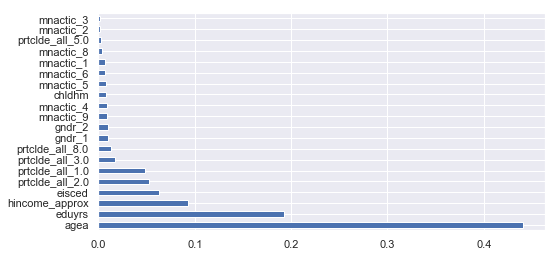

In [63]:
# Evaluate features_importance
feat_importances = pd.Series(best_random.feature_importances_, index=features.columns)
feat_importances.nlargest(20).plot(kind='barh')

*Correlation matrix*

The below correlation matrix of the top three features and the target feature underline the above assumtions. There is no strong correlation between the target feature (boolean newspaper use) and any of the three most important features.

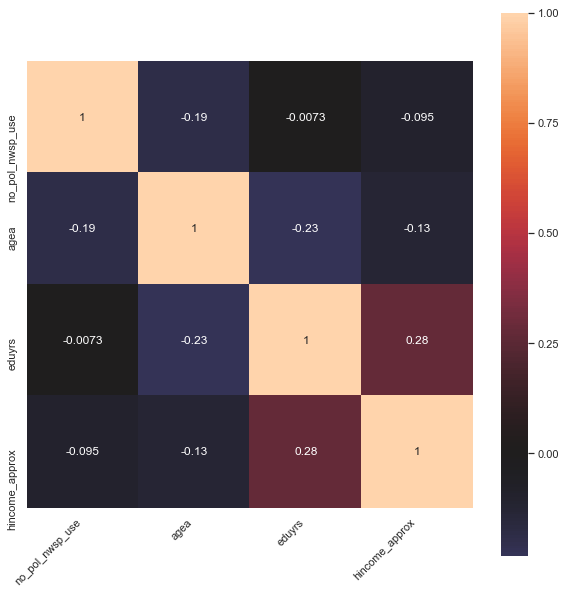

In [66]:
# Plot a correlation matrix of the top three features and the target feature to identify direct connections
df_corr = dfq3[['no_pol_nwsp_use', 'agea', 'eduyrs', 'hincome_approx']].corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(df_corr, center=0,annot=True,square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

*Final conclusion and visualization*
 
By not being able to predict the newspaper use based on the given features, we've learned that "Only old intellectual people read the newspaper"* is a cliche that could not be confirmed by the data at hand. 
Looking at the differences between the average answers of newspaper readers and non newspaper readers, we don't really see such a clear picture. Sure, the average age of the newspaper readers is a few years higher. But an 53 years average really isn't that high after all.
Further more, looking at the years of education and the houshold income, there is nearly no difference between both groups.


'* In case you haven't heard this one, don't worry about it, it seems to be wrong anyway.

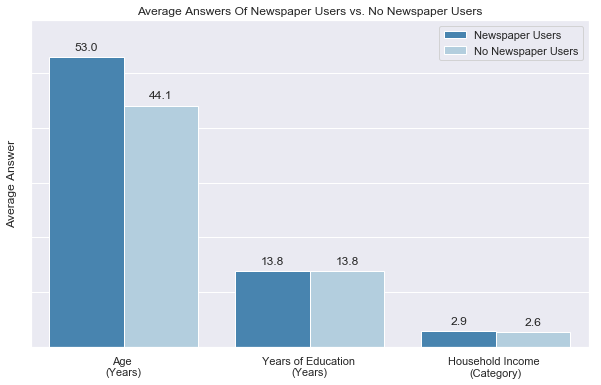

In [72]:
# Group data by nwsp use 
dfq3_group = dfq3.groupby('no_pol_nwsp_use', as_index=False).mean()[['agea', 'eduyrs', 'hincome_approx']]
dfq3_group = dfq3_group.reset_index(level=0)
dfq3_group = dfq3_group.melt(id_vars=['index'])

# Plot grouped bar chart
plt.figure(figsize=(10,6))
splot = sns.barplot(x='variable', y='value', hue='index', data=dfq3_group, palette="Blues_r")

# Add annotations for each bar
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# Format margins to get more space for the annotations
plot_margin = 4
x0, x1, y0, y1 = plt.axis()
plt.axis((x0, x1, y0, y1 + plot_margin))

# Change legend labels
handles, _ = splot.get_legend_handles_labels()
splot.legend(handles, ["Newspaper Users", "No Newspaper Users"])

# Add title and set axis labels
plt.title('Average Answers Of Newspaper Users vs. No Newspaper Users')
plt.ylabel('Average Answer');
splot.set_ylabel('Average Answer')    
splot.set_xlabel('')    
splot.set_yticklabels([])
splot.set_xticklabels(['Age \n(Years)', 'Years of Education \n(Years)', 'Household Income \n(Category)'])

plt.savefig("fig3-nwsp-use-diff.png",type="png",dpi=300)

plt.show()